In [111]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [112]:
from proj1_helpers import *
DATA_TRAIN_PATH = '' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data("../data/train.csv")

## Data Analyzing

In [113]:
# As we can see here, y only takes value -1 or 1:
for value in y:
    assert(value==1 or value==-1)
print("All value in y is equal either to 1 or -1.")


All value in y is equal either to 1 or -1.


This means that y is a binary variable. So should we modify y's coding to {0, 1} instead of {-1, 1} if we want the logistic regression methods to work?
Note that at first sight, logistic regression seems to be the best solution to fit the data since this method was designed for binary classification.

## Data Cleaning
We have to handle:
- outliers:
For the outliers we decided to remove the entire sample when at least one of its feature fields is considered as an outlier. We don't yet know how to determine if a given value is an outlier
- unasssigned values (-999):
If there more than [given threshold] non-assigned values in a given sample, we remove it. Otherwise we set the missing values to the mean of their corresponding feature.


### Using PCA to get rid of features that don't give enough information

In [114]:
for row in tX.T:
    row_cleaned = row[abs(row)<999]
    mean = np.mean(row_cleaned)
    row[abs(row)==999] = mean
    
tX = (tX-np.mean(tX,axis=0))/np.std(tX,axis=0)
C = 1/tX.shape[0]*tX.T.dot(tX)
    
eigenvalue, eigenvector = np.linalg.eig(C)
SUM = np.sum(eigenvalue)

idx = np.argsort(eigenvalue)[::-1]
eigenvector = eigenvector[:,idx]
eigenvalue = eigenvalue[idx]

F = 0
k = 0
while F < 0.90:
    F += eigenvalue[k]/SUM
    k = k+1   

eigenvector=eigenvector[:, :k]

tX = np.dot(eigenvector.T, tX.T).T

print(tX.shape)

(250000, 17)


(250000,)


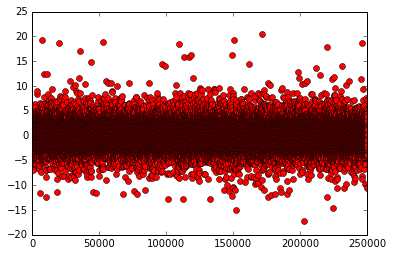

1.0


In [115]:
# TODO
print(np.shape(tX[:, 0]))
plt.plot(tX[:, 3], 'ro')
plt.show()
print(y[200])

## Some Helper Functions


In [116]:
# Some helper function:

def compute_gradient(y, tx, w):
    """Compute the gradient."""
    N = len(y)
    e = y - tx.dot(w)
    return (-1/N)*(tx.T).dot(e)

def compute_loss(y, tx, w):
    """Compute the cost by MSE"""
    N = len(y)
    e = y - tx.dot(w)
    return (1/(2*N))*((e.T).dot(e))

def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # concatenate column of ones of size (25000, 1)
    result = np.ones((x.shape[0], 1))
    for i in range(1, degree+1):
       result = np.concatenate((result, x ** i), axis=1)
    return result

#def build_poly(x, degree):
#    """polynomial basis functions for input data x, for j=0 up to j=degree."""
#    if (x.ndim == 1):
#        result = np.empty([degree+1, len(x)])
#        for i in range(degree+1):
#            result[i] = x ** i
#    else:
#        result = np.ones(np.shape(x))
#        for i in range(1, degree+1):
#            result = np.concatenate((result, x ** i), 1)
#    return result.T

def split_data(x, y, ratio, seed=1):
    """Randomly splits the data given in input into two subsets (test/train).
    The ratio determines the size of the training set."""
    np.random.seed(seed)
    size = y.shape[0]
    # randomly permutes array of intergers from 0 to size-1
    indexes = np.random.permutation(size)
    tr_size = int(np.floor(ratio * size))
    # get (randomly generated) indexes of training/testing set
    tr_indexes = indexes[0:tr_size]
    te_indexes = indexes[tr_size:]
    # split x (resp. y) into two subarrays x_tr, x_te (resp. y_tr, y_te)
    x_tr = x[tr_indexes]
    y_tr = y[tr_indexes]
    x_te = x[te_indexes]
    y_te = y[te_indexes]
    return [x_tr, y_tr, x_te, y_te]

def sigmoid_scal(t):
    """apply sigmoid function on t."""
    if(t > 0):
        return np.exp(t)/(1+np.exp(t))
    else:
        return 1/(1+np.exp(-t))
    
sigmoid = np.vectorize(sigmoid_scal)
    

def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    #print(len(tx[0]))
    loss = 0
    for index, row in enumerate(tx):
        loss += np.log(1+np.exp(row.dot(w)))-y[index]*(row).dot(w)
    return loss

def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    return tx.T.dot(sigmoid(tx.dot(w))-y)

def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descen using logistic regression.
    Return the loss and the updated w.
    """   
    grad = calculate_gradient(y,tx,w)
    loss = calculate_loss(y, tx, w)
    w -= gamma*grad
    return loss, w

## Functions to implement

In [131]:
def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    """performs linear regression using gradient descent algorithm. 
    Returns two arrays containing weights and loss values 
    at each step of the algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute gradient and loss
        gradient = compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)
        #update w
        w = w - gamma * gradient
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
    return w, loss


def least_squares_SGD(y, tx, initial_w, max_iters, gamma):
    """performs linear regression using stochastic gradient descent algorithm. 
    Returns two arrays containing weights and loss values 
    at each step of the algorithm."""
    ws = [initial_w]
    losses = []
    w = initial_w
    batch_size = 800 #try changing batch size
    
    for n_iter in range(max_iters):
        print("iteration", n_iter)
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            gradient = compute_gradient(minibatch_y, minibatch_tx, w)
            #compute new loss and w
            loss = compute_loss(y, tx, w) # add one loss per minibatch (compute mean)
            w = w - gamma * gradient
            # store loss and w in arrays
            ws.append(w)
            losses.append(loss)
                 
    return w, loss

def least_squares(y, tx):
    """performs linear regression by calculating 
    the least squares solution using normal equations.
    returns loss and optimal wieghts."""
    opt_w = np.linalg.inv(tx.T.dot(tx)).dot(tx.T).dot(y)
    #computes the loss using MSE
    mse = compute_loss(y, tx, opt_w)
    return opt_w, mse
    
def ridge_regression(y, tx, lambda_):
    """implement ridge regression. This calculates the MSE while taking in 
    accout a regularizer that is determined by lambda. This has for effect to
    penalize/avoid large weights in order to avoid overfitting."""
    # tx is the polynomial basis
    opt_w = (np.linalg.inv(tx.T.dot(tx)+lambda_*2*len(y)*np.identity(tx.shape[1])).dot(tx.T)).dot(y)
    mse = compute_loss(y, tx, opt_w)
    return opt_w, mse

def logistic_regression(y, x, max_iter, gamma):
    # init parameters
    #max_iter = 10000
    threshold = 1e-8
    #gamma = 0.001
    losses = []
    # reshape the array to please numpy
    y.shape = (len(y), 1)

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        # 1. using gradient descent
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        # 2. using stochastic gradient descent
        # ---------- TODO ----------
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criteria
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    #visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
    print("The loss={l}".format(l=calculate_loss(y, tx, w)))

    
def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):
    #TODO
    raise NotImplementedError


In [135]:
# logistic regression test
max_iter = 1000
gamma = 0.00001
y2 = (y+1)/2
print(y2)
for elem in y2:
    assert(elem == 0 or elem == 1)
print("ok")
x3 = tX[0:10000]
y3 = y2[0:10000]
logistic_regression(y3, x3, max_iter, gamma)


[ 1.  0.  0. ...,  1.  0.  0.]
ok
Current iteration=0, the loss=[ 6931.4718056]
Current iteration=100, the loss=[ 5359.13336689]
Current iteration=200, the loss=[ 5324.89125577]
Current iteration=300, the loss=[ 5321.85606476]
Current iteration=400, the loss=[ 5321.5013338]
Current iteration=500, the loss=[ 5321.45463647]
Current iteration=600, the loss=[ 5321.44808903]
Current iteration=700, the loss=[ 5321.44713703]
Current iteration=800, the loss=[ 5321.44699563]
Current iteration=900, the loss=[ 5321.44697436]
The loss=[ 5321.44697114]


## Use Polynomial Regression to find the optimal degree

RMSE for degree 1 : 0.823948540296
RMSE for degree 2 : 0.797355528255
RMSE for degree 3 : 25.9747213842
RMSE for degree 4 : 40.2177231713
RMSE for degree 5 : 63.6673060443
The best degree among those we tested is 2 .


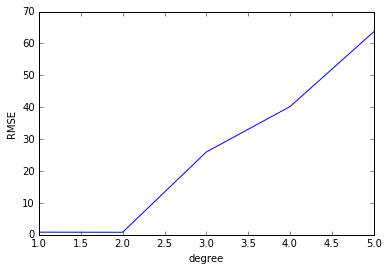

In [205]:
def polynomial_regression():
    """For each degree, constructs the polynomial basis function expansion of the data
       and stores the corresponding RMSE in an array. At the end we chose the degree that
       generated the smallest RMSE. Of course we cannot test all degrees so this is not
       optimal but it helps us having a good idea of the optimal degree value."""
    # define parameters
    degrees = [1, 2, 3, 4, 5]
    
    # for each degree we store the corresponding RMSE in this array
    rmse_array = np.array([])

    for ind, degree in enumerate(degrees):
        # form the data to do polynomial regression:
        polynomial_basis = build_poly(tX, degree)
        
        # least square and calculate rmse:
        mse, weight = least_squares(y, polynomial_basis)
        rmse = np.sqrt(2*mse)
        rmse_array = np.append(rmse_array, rmse)
        print("RMSE for degree", degree, ":", rmse)
    
    # plot the RMSE in function of the degree
    plt.plot(degrees, rmse_array)
    plt.xlabel('degree')
    plt.ylabel('RMSE')
    
    #compute the best degree
    best_degree = degrees[np.argmin(rmse_array)]
    print("The best degree among those we tested is", best_degree, ".")

polynomial_regression()

### Results
Looking at the results, it seems like 2 is the optimal degree. However, we might be overfitting the data because there is no regularization step in polynomial_regression. Thus we'll use the Ridge regression, which uses a regularizer that depends on a parameter lambda.
We'll compute the RMSE for different lambda and degree values in order to determine the best ones.

## Use Ridge Regression to determine optimal lambda

In [89]:
def ridge_regression_demo(x, y, ratio, seed):
    """Calculate polyomial basis tX from x with given degree,
    splits the data according to given ratio and then run
    ridge regression on tX, y with different lambda values.
    At the end we plot the RMSEs of training/testing set in
    function of lambda in order to determine the best lambda value"""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    degrees = [1, 2]
    
    # split the data, and return train and test data:
    x_tr, y_tr, x_te, y_te = split_data(x, y, ratio, seed)
    
    #calculate test/train RMSE for each lambda and store them in lists
    rmse_list_tr = np.empty([len(degrees), len(lambdas)])
    rmse_list_te = np.empty([len(degrees), len(lambdas)])
    optimal_weights = np.empty([np.shape(tX)[1]])
    best_RMSE = 10e10
    for i, degree in enumerate(degrees):
        # for each lambda, store the best RMSE and the degree that generated it
        for j, lambd in enumerate(lambdas):
            # compute polynomial basis from given degree
            poly_basis_tr = build_poly(x_tr, degree)
            poly_basis_te = build_poly(x_te, degree)
            # compute training and testing (R)MSE for current lambda/degree
            w_tr, mse_tr = ridge_regression(y_tr, poly_basis_tr,lambd)
            mse_te = compute_loss(y_te, poly_basis_te, w_tr)
            rmse_tr = np.sqrt(2*mse_tr)
            rmse_te = np.sqrt(2*mse_te)
            #print("Training RMSE for lambda =", lambd, "and degree", degree, ":", rmse_tr, "\n")
            #print("Testing RMSE for lambda =", lambd, "and degree", degree, ":", rmse_te, "\n")
            # Store RMSEs in arrays
            rmse_list_tr[i][j] = rmse_tr
            rmse_list_te[i][j] = rmse_te
            # we do this to get optimal weights
            if(best_RMSE > rmse_tr):
                best_RMSE = rmse_tr
                optimal_weights = w_tr
    
    # get best degree, lambda, RMSE
    degree_index_tr, lambd_index_tr = np.where(rmse_list_tr == rmse_list_tr.min())
    degree_index_tr, lambd_index_tr = (degree_index_tr[0],lambd_index_tr[0])
    best_rmse_tr = rmse_list_tr[degree_index_tr][lambd_index_tr]
    print("Best training RMSE is", best_rmse_tr, "with degree", degrees[degree_index_tr], "and lambda=", lambdas[lambd_index_tr], "\n")
    return optimal_weights, best_RMSE
    
seed = 1
split_ratio = 0.8
w, loss = ridge_regression_demo(tX, y, split_ratio, seed)

Best training RMSE is 0.799059367416 with degree 2 and lambda= 1e-05 



## Computing the weights with different methods

In [103]:
#initial values
gamma = 1e-7
initial_w = 0*np.ones(len(tX[0])) #try changing initial w
max_iters = 10
poly_basis = build_poly(tX, 2)

### Least Squares

In [104]:
w, loss = least_squares(y, tX)
print(loss)

0.339686809915


### Least Squares with polynomial basis

In [101]:
w, loss = least_squares(y, poly_basis)
print(loss)

0.317887919219


### Least Squares - Gradient Descent

In [71]:
w, loss = least_squares_GD(y, tX, initial_w, max_iters, gamma)
print(loss)

0.433339221781


### Least Squares - Stochastic Gradient Descent

In [69]:
w, loss = least_squares_SGD(y, tX, initial_w, max_iters, gamma)
print(loss)

0.386047330834


### Ridge Regression

In [86]:
# to find optimal degree and lambda, check "Use RR to determine optimal
# lambda and degree" section
degree = 2
poly_basis = build_poly(tX, 2)
lambda_ = 1e-05
w, loss = ridge_regression_demo(y, poly_basis, lambda_)
print(loss)

0.799208298279


### Ridge regression with data splitting and chosing best lambda/deg

In [88]:
seed = 1
split_ratio = 0.8
w, loss = ridge_regression_demo(tX, y, split_ratio, seed)
print(loss)

Best training RMSE is 0.799059367416 with degree 2 and lambda= 1e-05 

0.799059367416


## Generate predictions and save ouput in csv format for submission:

In [112]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
print("done")

done


In [115]:
base_poly_x = build_poly(tX_test, 2)
poly_basis = build_poly(tX, 2)
w, loss = least_squares(y, poly_basis)
print("done")

done


In [117]:
OUTPUT_PATH = '../data/submissionData/least_squares_poly_basis.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w, base_poly_x)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)
print("done")

done
